In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from io import BytesIO
from textwrap import fill
from zipfile import ZipFile
from urllib.request import urlopen
from matplotlib.ticker import FormatStrFormatter

In [ ]:
'''
CONFIGURAÇÃO DE RESOLUÇÃO

- Em caso de utilização dos gráficos gerados neste notebook
para apresentação externa, i.e. download das imagens, descomente
e execute linha de código abaixo. Caso deseje visualizá-los adequadamente
dentro deste notebook, mantenha-a inalterada ou altere o valor para 72 (padrão).
'''

mpl.rcParams['figure.dpi'] = 288

!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

####Seleção e pré-processamento dos dados



In [4]:
ENADE_2021_URL = "https://github.com/EudeMonteiro/KDD-Enade-UFPA-Courses/raw/main/microdados2021_arq3.zip"
ENADE_2017_URL = "https://github.com/renan-cunha/EnadeData/raw/main/microdados_enade_2017.zip"

UFPA_CODE = 569
PRESENT_STUDENT_CODE = 555
NUM_SK_QUESTIONS = 27 #Número de questões da componente de conhecimento específico

#Os cursos de Estatística e Ciências Naturais não são avaliados no Enade
UFPA_COURSE_CODES = {"Ciência da Computação": 12025,                                         
                     "Física (Bacharelado)": 12000,
                     "Física (Licenciatura)": 12022,
                     "Matemática (Licenciatura)": 11999,
                     "Química (Bacharelado)": 12007,
                     "Química (Licenciatura)": 12026,                     
                     "Sistemas de Informação": 60886,                   
                     }

NATIONAL_COURSE_CODES = {4004: 'Ciência da Computação', 
                         1401: 'Física (Bacharelado)', 
                         1402: 'Física (Licenciatura)', 
                         702: 'Matemática (Licenciatura)', 
                         1501: 'Química (Bacharelado)', 
                         1502: 'Química (Licenciatura)', 
                         4006: 'Sistemas de Informação'
                         }

QUESTIONS_SUBJECTS_URL = "https://raw.githubusercontent.com/EudeMonteiro/KDD-Enade-UFPA-Courses/main/databases/"
QUESTIONS_SUBJECTS_DB_CODES = {4004: "CC",
                               1401: "FIS_BAC",
                               1402: "FIS_LIC",
                               702:  "MAT",
                               1501: "QUIM_BAC",
                               1502: "QUIM_LIC",
                               4006: "SI"
                               }

HEI_CODES_URL = "https://raw.githubusercontent.com/EudeMonteiro/KDD-Enade-UFPA-Courses/main/databases/hei.csv"

DTYPES = {"DS_VT_ACE_OFG" : str,
          "DS_VT_ACE_OCE" : str,
          "DS_VT_ESC_OCE" : str,
          "DS_VT_ESC_OFG" : str}


def get_raw_data(url: str, extract_to: str ='.'):
    """
    Realiza o download dos microdados 
    hospedados em repositórios externos
    """
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)


def filter_courses_results(df:pd.DataFrame) -> pd.DataFrame:
    """
    Filtra somente os participantes presentes na prova,
    que tiveram resultado válido e que preencheram o
    cartão-resposta do exame
    """
    df = df.loc[df["CO_GRUPO"].isin(NATIONAL_COURSE_CODES.keys())]
    df = df.loc[(df["TP_PRES"] == PRESENT_STUDENT_CODE) &
                (df["TP_PR_GER"] == PRESENT_STUDENT_CODE) &
                (~df["DS_VT_ESC_OCE"].isna())]

    return df


def reduce_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Seleciona os atributos relevantes para a
    realização da análise dos dados
    """

    columns = ["NU_ANO",
               "CO_IES",
               "CO_GRUPO",
               "CO_CURSO",
               "CO_CATEGAD",
               "CO_ORGACAD",
               "DS_VT_ACE_OCE",
               "DS_VT_ACE_OFG",
               "DS_VT_ESC_OCE",
               "NT_CE",
               "NT_GER",
               "NT_OBJ_CE",
               "TP_PRES",
               "TP_PR_GER",
               "QE_I08"]
    
    return df[columns]


if __name__ == '__main__':

    get_raw_data(url=ENADE_2017_URL, extract_to='.')
    #Enade_2021 = pd.read_csv("/content/microdados2021_arq3.txt", sep=";", decimal=".", dtype=DTYPES)
    raw_data = pd.read_csv("/content/3.DADOS/MICRODADOS_ENADE_2017.txt", sep=";", decimal=",", dtype=DTYPES)
    selected_data = filter_courses_results(raw_data)
    Enade_2017 = reduce_data(selected_data)

    #pd.set_option('max_columns', None)
    #pd.reset_option('max_columns')
    #display(Enade_2017)
    
    

####Funções auxiliares de limpeza e mineração de dados

In [57]:
def get_subjects_per_question(questions_subjects_df: pd.DataFrame) -> pd.Series:
  
  count_first_subject  = questions_subjects_df["FIRST_SUBJECT"].value_counts()
  count_second_subject = questions_subjects_df["SECOND_SUBJECT"].value_counts()
  count_third_subject = questions_subjects_df["THIRD_SUBJECT"].value_counts()

  subjects_per_question = count_first_subject.add(count_second_subject, fill_value = 0)
  subjects_per_question = subjects_per_question.add(count_third_subject, fill_value = 0)
  subjects_per_question.sort_index(inplace=True)

  return subjects_per_question.astype(int).values


def get_invalid_subjects(questions_subjects_df: pd.DataFrame) -> list:
  
  subjects = questions_subjects_df["FIRST_SUBJECT"].drop_duplicates().to_list()
  invalid_subjects = []

  for i in subjects:
    if not questions_subjects_df.loc[questions_subjects_df["FIRST_SUBJECT"] == i, "VALIDITY"].any():
      invalid_subjects.append(i)

  return invalid_subjects


def display_score_per_subject(questions_subjects_df: pd.DataFrame, df: pd.DataFrame):
  
    subjects = pd.unique(questions_subjects_df[["FIRST_SUBJECT","SECOND_SUBJECT","THIRD_SUBJECT"]].values.ravel('K'))
    subjects = pd.Series(subjects).dropna().sort_values(ignore_index=True)

    subjects_score = pd.DataFrame({"Conteúdo" : subjects, "Acertos" : 0})

    question_columns = ["DS_VT_ACE_OCE",
                        "DS_VT_ACE_OFG"]

    marked_keys = df[question_columns[0]]


    for index in range(questions_subjects_df.shape[0]):

        first_subject  = questions_subjects_df.loc[index, "FIRST_SUBJECT"]
        second_subject = questions_subjects_df.loc[index, "SECOND_SUBJECT"]
        third_subject = questions_subjects_df.loc[index, "THIRD_SUBJECT"]


        result = marked_keys[marked_keys.str[index] == '1'].shape[0]

        subjects_score.loc[subjects_score["Conteúdo"] == first_subject, "Acertos"] += result

        if second_subject:
            subjects_score.loc[subjects_score["Conteúdo"] == second_subject, "Acertos"] += result

            if third_subject:
                subjects_score.loc[subjects_score["Conteúdo"] == third_subject, "Acertos"] += result



    subjects_per_question = get_subjects_per_question(questions_subjects_df)
    subject_score_column = subjects_score["Acertos"] * 100 / (subjects_per_question * df.shape[0])
    subjects_score["Nota (%)"] = subject_score_column.round(2)

    invalid_subjects = get_invalid_subjects(questions_subjects_df)
    rows_to_drop = subjects_score["Conteúdo"].isin(invalid_subjects)

    subjects_score.drop(subjects_score[rows_to_drop].index, inplace=True)

    return subjects_score


####Visualização gráfica

In [67]:

def plot_performance_graph(group_code: int, ratio_graph=True, absolute_graph=True):
    """
    Plota os gráficos de comparativo de desempenho.

    Parâmetros:
    - group_code: Código do curso (ver tabela de códigos no driver-code)
    - ratio_graph: Habilita a exibição do gráfico de razão de desempenho
    - absolute_graph: Habilita a exibição do gráfico de percentual absoluto de desempenho
    """

    sk_national_df = Enade_2017[Enade_2017["CO_GRUPO"] == group_code]
    sk_ufpa_df = sk_national_df[sk_national_df["CO_CURSO"] == UFPA_COURSE_CODES[NATIONAL_COURSE_CODES[group_code]]]
    questions_subjects_df = pd.read_csv(QUESTIONS_SUBJECTS_URL + QUESTIONS_SUBJECTS_DB_CODES[group_code] + "_questions_subjects.csv")
    
    subject_score_ufpa  = display_score_per_subject(questions_subjects_df, sk_ufpa_df)
    subject_score_national = display_score_per_subject(questions_subjects_df, sk_national_df)

    #display(display_score_per_subject(questions_subjects_df, sk_ufpa_df))

    merged_score_df = pd.DataFrame({"Nota UFPA (%)":  subject_score_ufpa["Nota (%)"],
                                    "Nota Enade (%)": subject_score_national["Nota (%)"]
                                    }).set_index(subject_score_national["Conteúdo"])

    merged_score_df["Max"] = merged_score_df[["Nota UFPA (%)", "Nota Enade (%)"]].max(axis=1)

    #Lambda function to calculate the score ratio
    ratio = lambda col: (col["Nota UFPA (%)"] / col["Nota Enade (%)"]).round(2)
    merged_score_df["Razão"] = merged_score_df.apply(ratio, axis=1)
    
    #Graph plotting formatting settings
    plt.rcParams.update({"text.usetex": True})
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    
    if ratio_graph:
        title = f"Razão do percentual de acerto UFPA-Brasil em {NATIONAL_COURSE_CODES[group_code]} por tema no Enade 2017"

        fig, ax = plt.subplots(figsize=(8,8))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axvline(x=1.0, color="red")
        ax.grid(axis = 'x', color ='white', linestyle='-')
        ax.set_xlabel("Razão do percentual de acerto")

        merged_score_df.sort_values(by = ["Razão"], inplace=True)        
        labels = [fill(x, len(x)/2 + 5) if len(x) > 60 else fill(x, 100) for x in merged_score_df.index]

        plt.barh(labels, merged_score_df["Razão"], color = 'k', height=0.6)
        
        r = .2
        min_xlim = round(min(merged_score_df["Razão"]) / r) * r
        xticks = np.linspace(min_xlim - r, 2 - min_xlim + r, 9)
        ax.set_xticks(xticks)
        ax.set_xticklabels(list(map(str, xticks)))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        plt.xlim(min_xlim-r, 2 - min_xlim+r)       
        #plt.title(title, fontsize = 22, pad=20, x=0.33, y=1)
        #plt.tight_layout()

        #display(merged_score_df)
        #fig.savefig("ratio_graph.pdf", format='pdf', dpi=300)    
        plt.show()
        print()


    if absolute_graph:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis = 'x', color ='white', linestyle='-')
        ax.set_xlabel("Percentual de acerto")
            
        title = f"Percentual de acerto por tema em {NATIONAL_COURSE_CODES[group_code]} no Enade 2017"
        
        ind = np.arange(merged_score_df.shape[0])
        width = 0.35

        merged_score_df.sort_values(by = ["Nota UFPA (%)", "Razão"], ascending=False, inplace=True)
        labels = [fill(x, len(x)/2 + 5) if len(x) > 60 else fill(x, 100) for x in merged_score_df.index]

        ax.barh(ind, merged_score_df["Nota UFPA (%)"], width, color='dodgerblue', label = "UFPA")
        ax.barh(ind + width, merged_score_df["Nota Enade (%)"], width, 
                color='mediumspringgreen', label = "Brasil")
        
        ax.set(yticks=ind+(width/2), yticklabels=labels)
        ax.legend(fontsize="large", loc='lower right')

        plt.xlim(0,100)
        #plt.title(title, fontsize = 22, pad=20, x=0.33, y=1)
        #plt.tight_layout()
        plt.gca().invert_yaxis()        
        fig.savefig("absolute_graph.pdf", format='pdf', dpi=300)     
        plt.show()
        print()

def household_income_score_correlation(group_code) -> None:
    """
    Exibe um gráfico de correlação entre a renda 
    familiar do discente e sua nota geral no exame
    """

    df_ufpa = Enade_2017[(Enade_2017["CO_CURSO"] == UFPA_COURSE_CODES[NATIONAL_COURSE_CODES[group_code]])]    
    df_ufpa = df_ufpa[["QE_I08", "NT_GER"]].dropna()   
    df_ufpa = df_ufpa[df_ufpa['QE_I08'].map(df_ufpa['QE_I08'].value_counts()) > 1]
    
    #display(df_ufpa)

    fig, ax = plt.subplots(figsize=(8,8))
    
    custom_dict = dict(linewidth=1.3)
    df_ufpa.boxplot(column=['NT_GER'], by='QE_I08', ax=ax, 
                    color='black', medianprops=dict(color='orange', linewidth=2),
                    boxprops=custom_dict,
                    whiskerprops=custom_dict,
                    capprops=custom_dict,
                    flierprops=dict(markersize=10))
    
    ax.set_ylim(0, 100)
    ax.set_xlabel("Categoria de renda")
    ax.set_ylabel("Nota geral (\%)")
    
    title = f"Correlação entre nota geral e renda familiar\nem {NATIONAL_COURSE_CODES[group_code]} no Enade 2017"
    plt.suptitle(title, fontsize=22)
    plt.title("")
    plt.show()
    

def show_best_hei_ranking(group_code, public_only) -> None:

    questions_subjects_df = pd.read_csv(QUESTIONS_SUBJECTS_URL + QUESTIONS_SUBJECTS_DB_CODES[group_code] + "_questions_subjects.csv")
    hei_df = pd.read_csv(HEI_CODES_URL)
    hei_dict = dict(hei_df.values)


    subjects = pd.unique(questions_subjects_df[["FIRST_SUBJECT","SECOND_SUBJECT","THIRD_SUBJECT"]].values.ravel('K'))
    subjects = pd.Series(subjects).dropna().sort_values(ignore_index=True)

    invalid_subjects = get_invalid_subjects(questions_subjects_df)

    subjects = np.setdiff1d(subjects, invalid_subjects)

    #apenas universidades públicas federais
    if public_only:
        hei_codes = pd.unique(Enade_2017.loc[(Enade_2017["CO_GRUPO"] == group_code) & 
                                             (Enade_2017["CO_CATEGAD"] == 1) &
                                             (Enade_2017["CO_ORGACAD"] == 10028), "CO_IES"])

    else:
        hei_codes = pd.unique(Enade_2017.loc[Enade_2017["CO_GRUPO"] == group_code, "CO_IES"])


    scores = []

    for code in hei_codes:
        hei_df = Enade_2017.loc[(Enade_2017["CO_GRUPO"] == group_code) & (Enade_2017["CO_IES"] == code)]
        score = display_score_per_subject(questions_subjects_df, hei_df)["Nota (%)"].values.tolist()
        
        scores.append([code, score])

    best_hei = [max(scores, key=lambda x:x[1][i]) for i in range(len(subjects))]

    df_columns = ["Tema", 
                  "IES", 
                  "Nº. de participantes", 
                  "Melhor curso", 
                  "UFPA"]
        
    tuples = [("", "Tema"),
              ("", "IES"),
              ("", "Nº de participantes"),
              ("Desempenho (%)", "Melhor curso"),
              ("Desempenho (%)", "UFPA")]

    idx = pd.MultiIndex.from_tuples(tuples)

    best_hei_scores = np.asarray(best_hei, dtype='object')[:, 1:].flatten().tolist()
    best_hei_codes = np.asarray(best_hei, dtype='object').T[0]

    hei_data = [hei_dict.get(value, value) for value in best_hei_codes]
    num_participants = [Enade_2017[(Enade_2017["CO_GRUPO"] == group_code) & (Enade_2017["CO_IES"] == code)].shape[0] for code in best_hei_codes]
    
    scores_data = np.array(best_hei_scores).diagonal()


    data = [subjects, 
            hei_data,
            num_participants,
            scores_data,
            display_score_per_subject(questions_subjects_df, 
                                    Enade_2017[Enade_2017["CO_CURSO"] == UFPA_COURSE_CODES[NATIONAL_COURSE_CODES[group_code]]]).reset_index()["Nota (%)"]]

    df_best_hei_per_subject = pd.DataFrame(dict(zip(df_columns, data)))
    df_best_hei_per_subject.columns=idx

    pd.set_option('display.max_colwidth', None)
    display(df_best_hei_per_subject)

    return



Análise comparativa de desempenho dos cursos do ICEN no ENADE 2017

Códigos dos cursos:

Ciência da Computação:   	4004
Física (Bacharelado):   	1401
Física (Licenciatura):   	1402
Matemática (Licenciatura):   	702
Química (Bacharelado):   	1501
Química (Licenciatura):   	1502
Sistemas de Informação:   	4006

Insira um código de curso: 1501


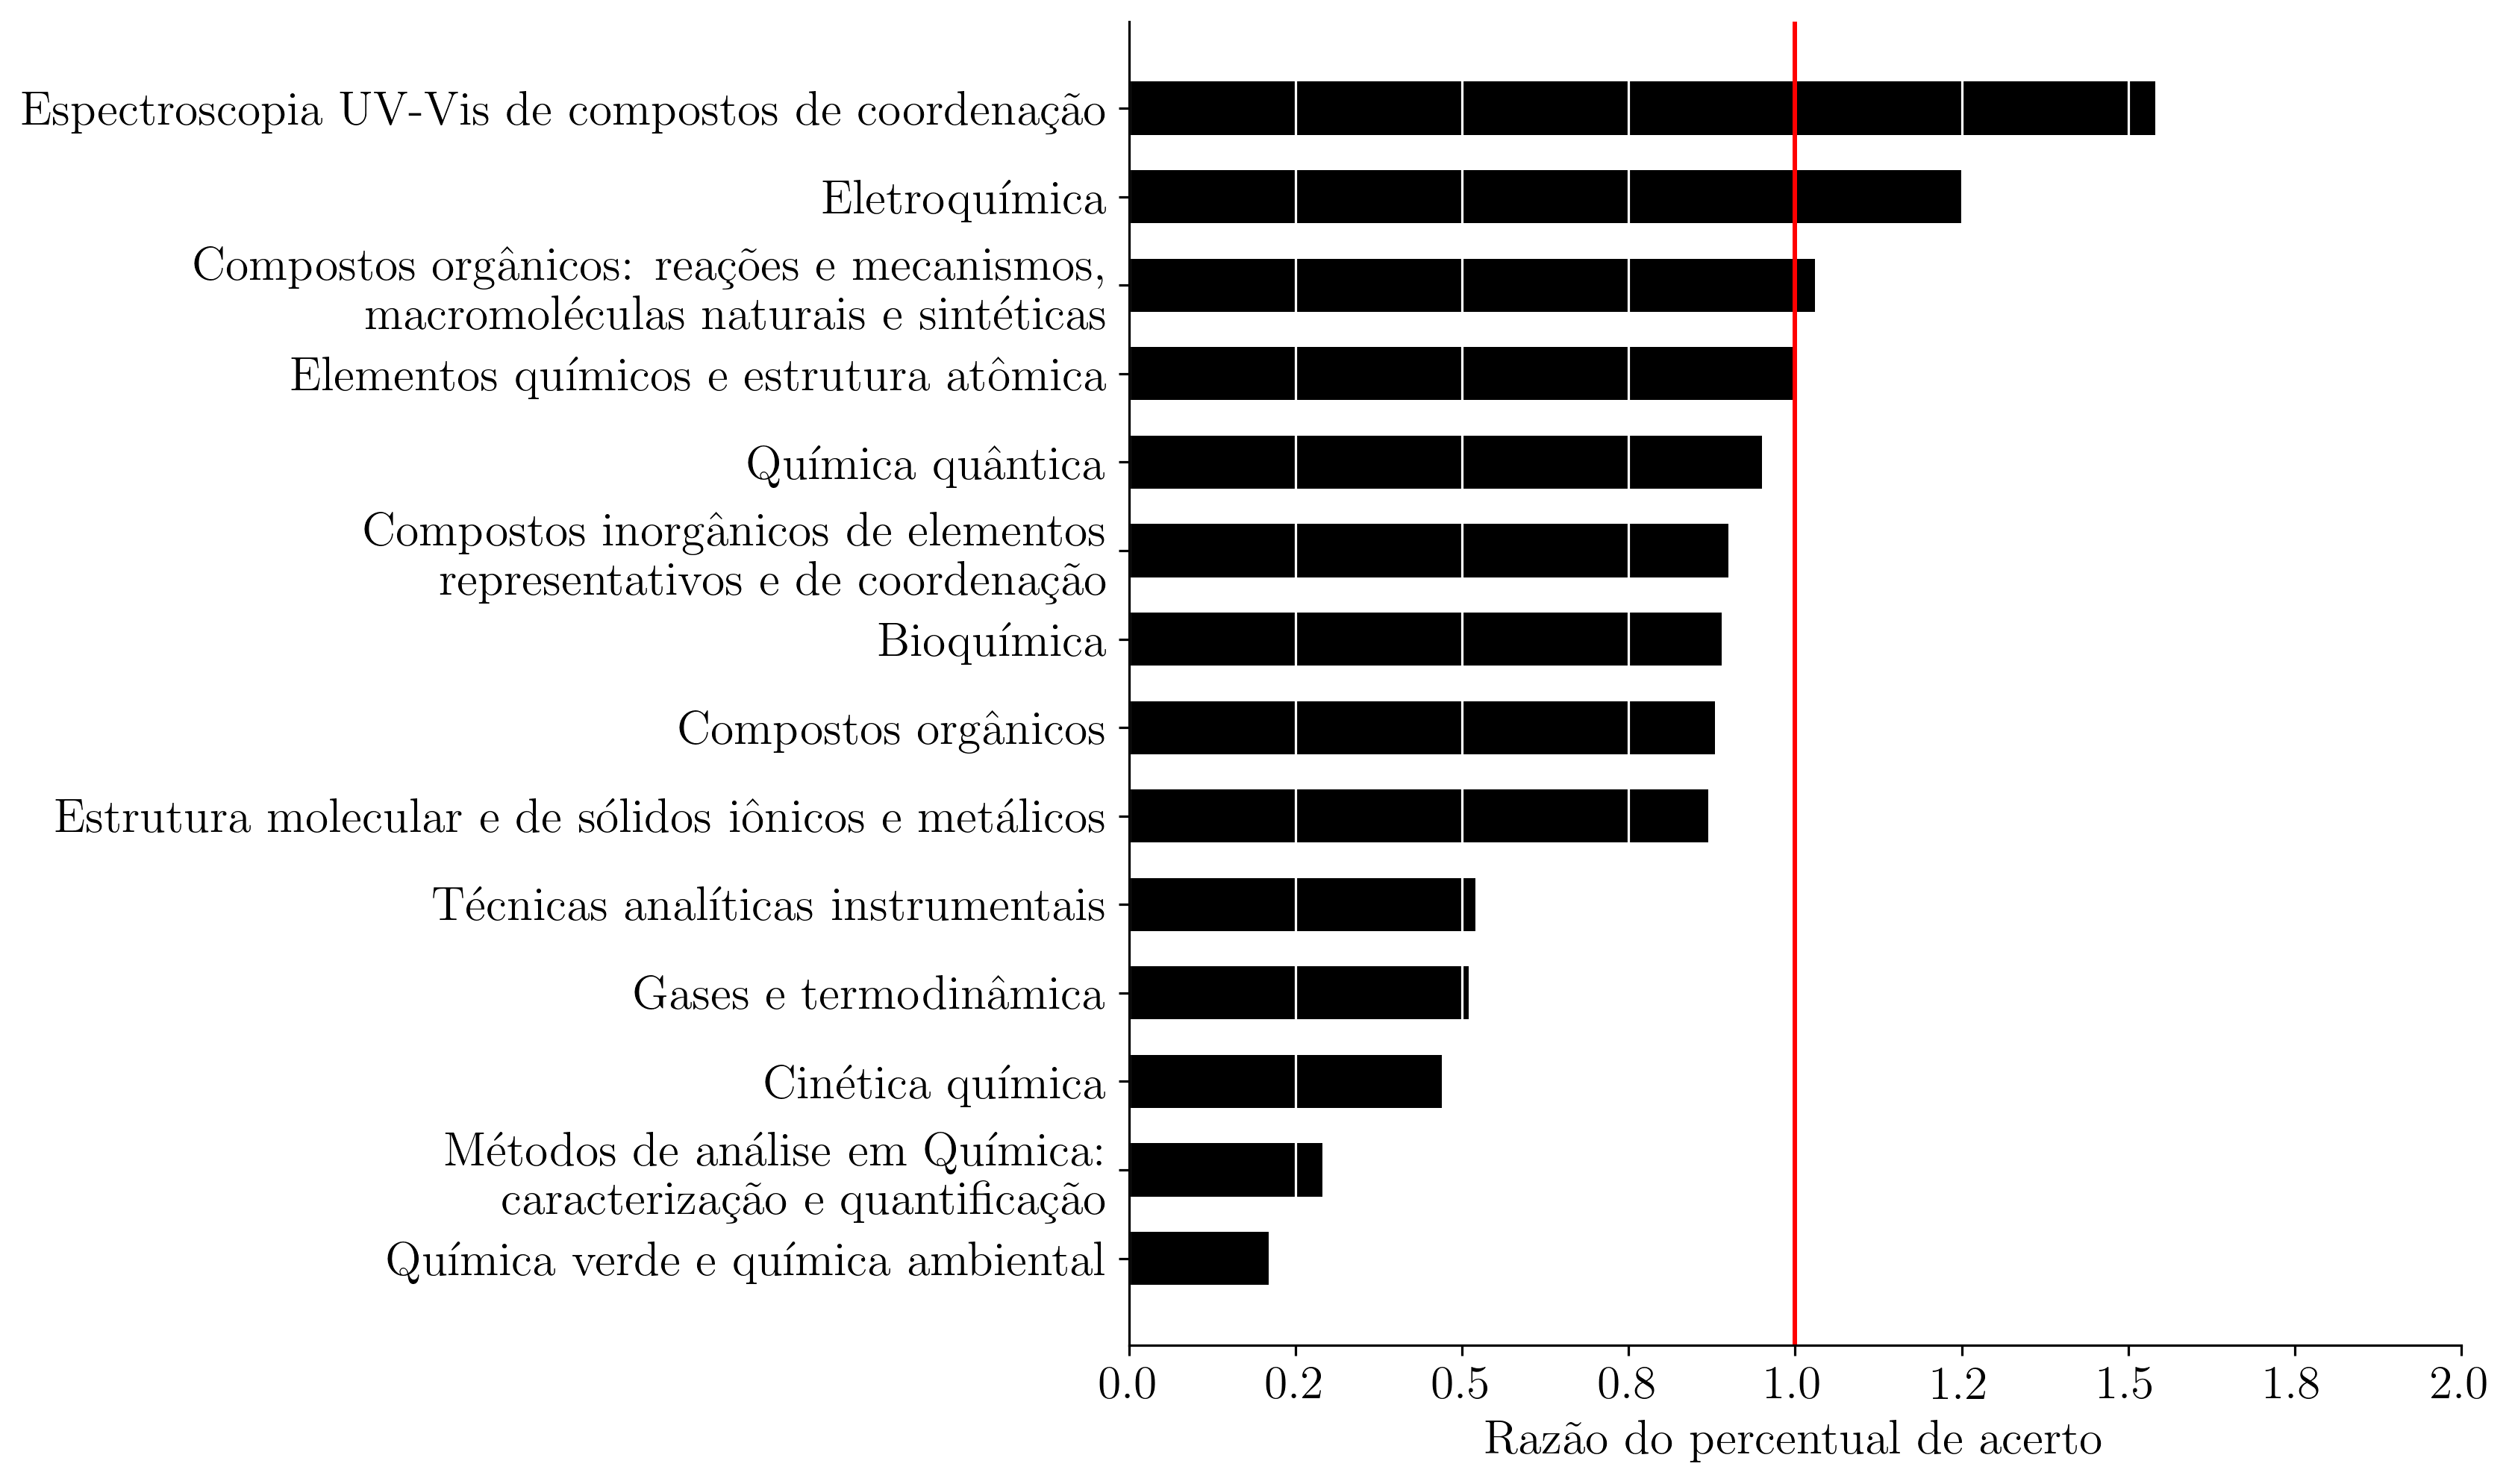

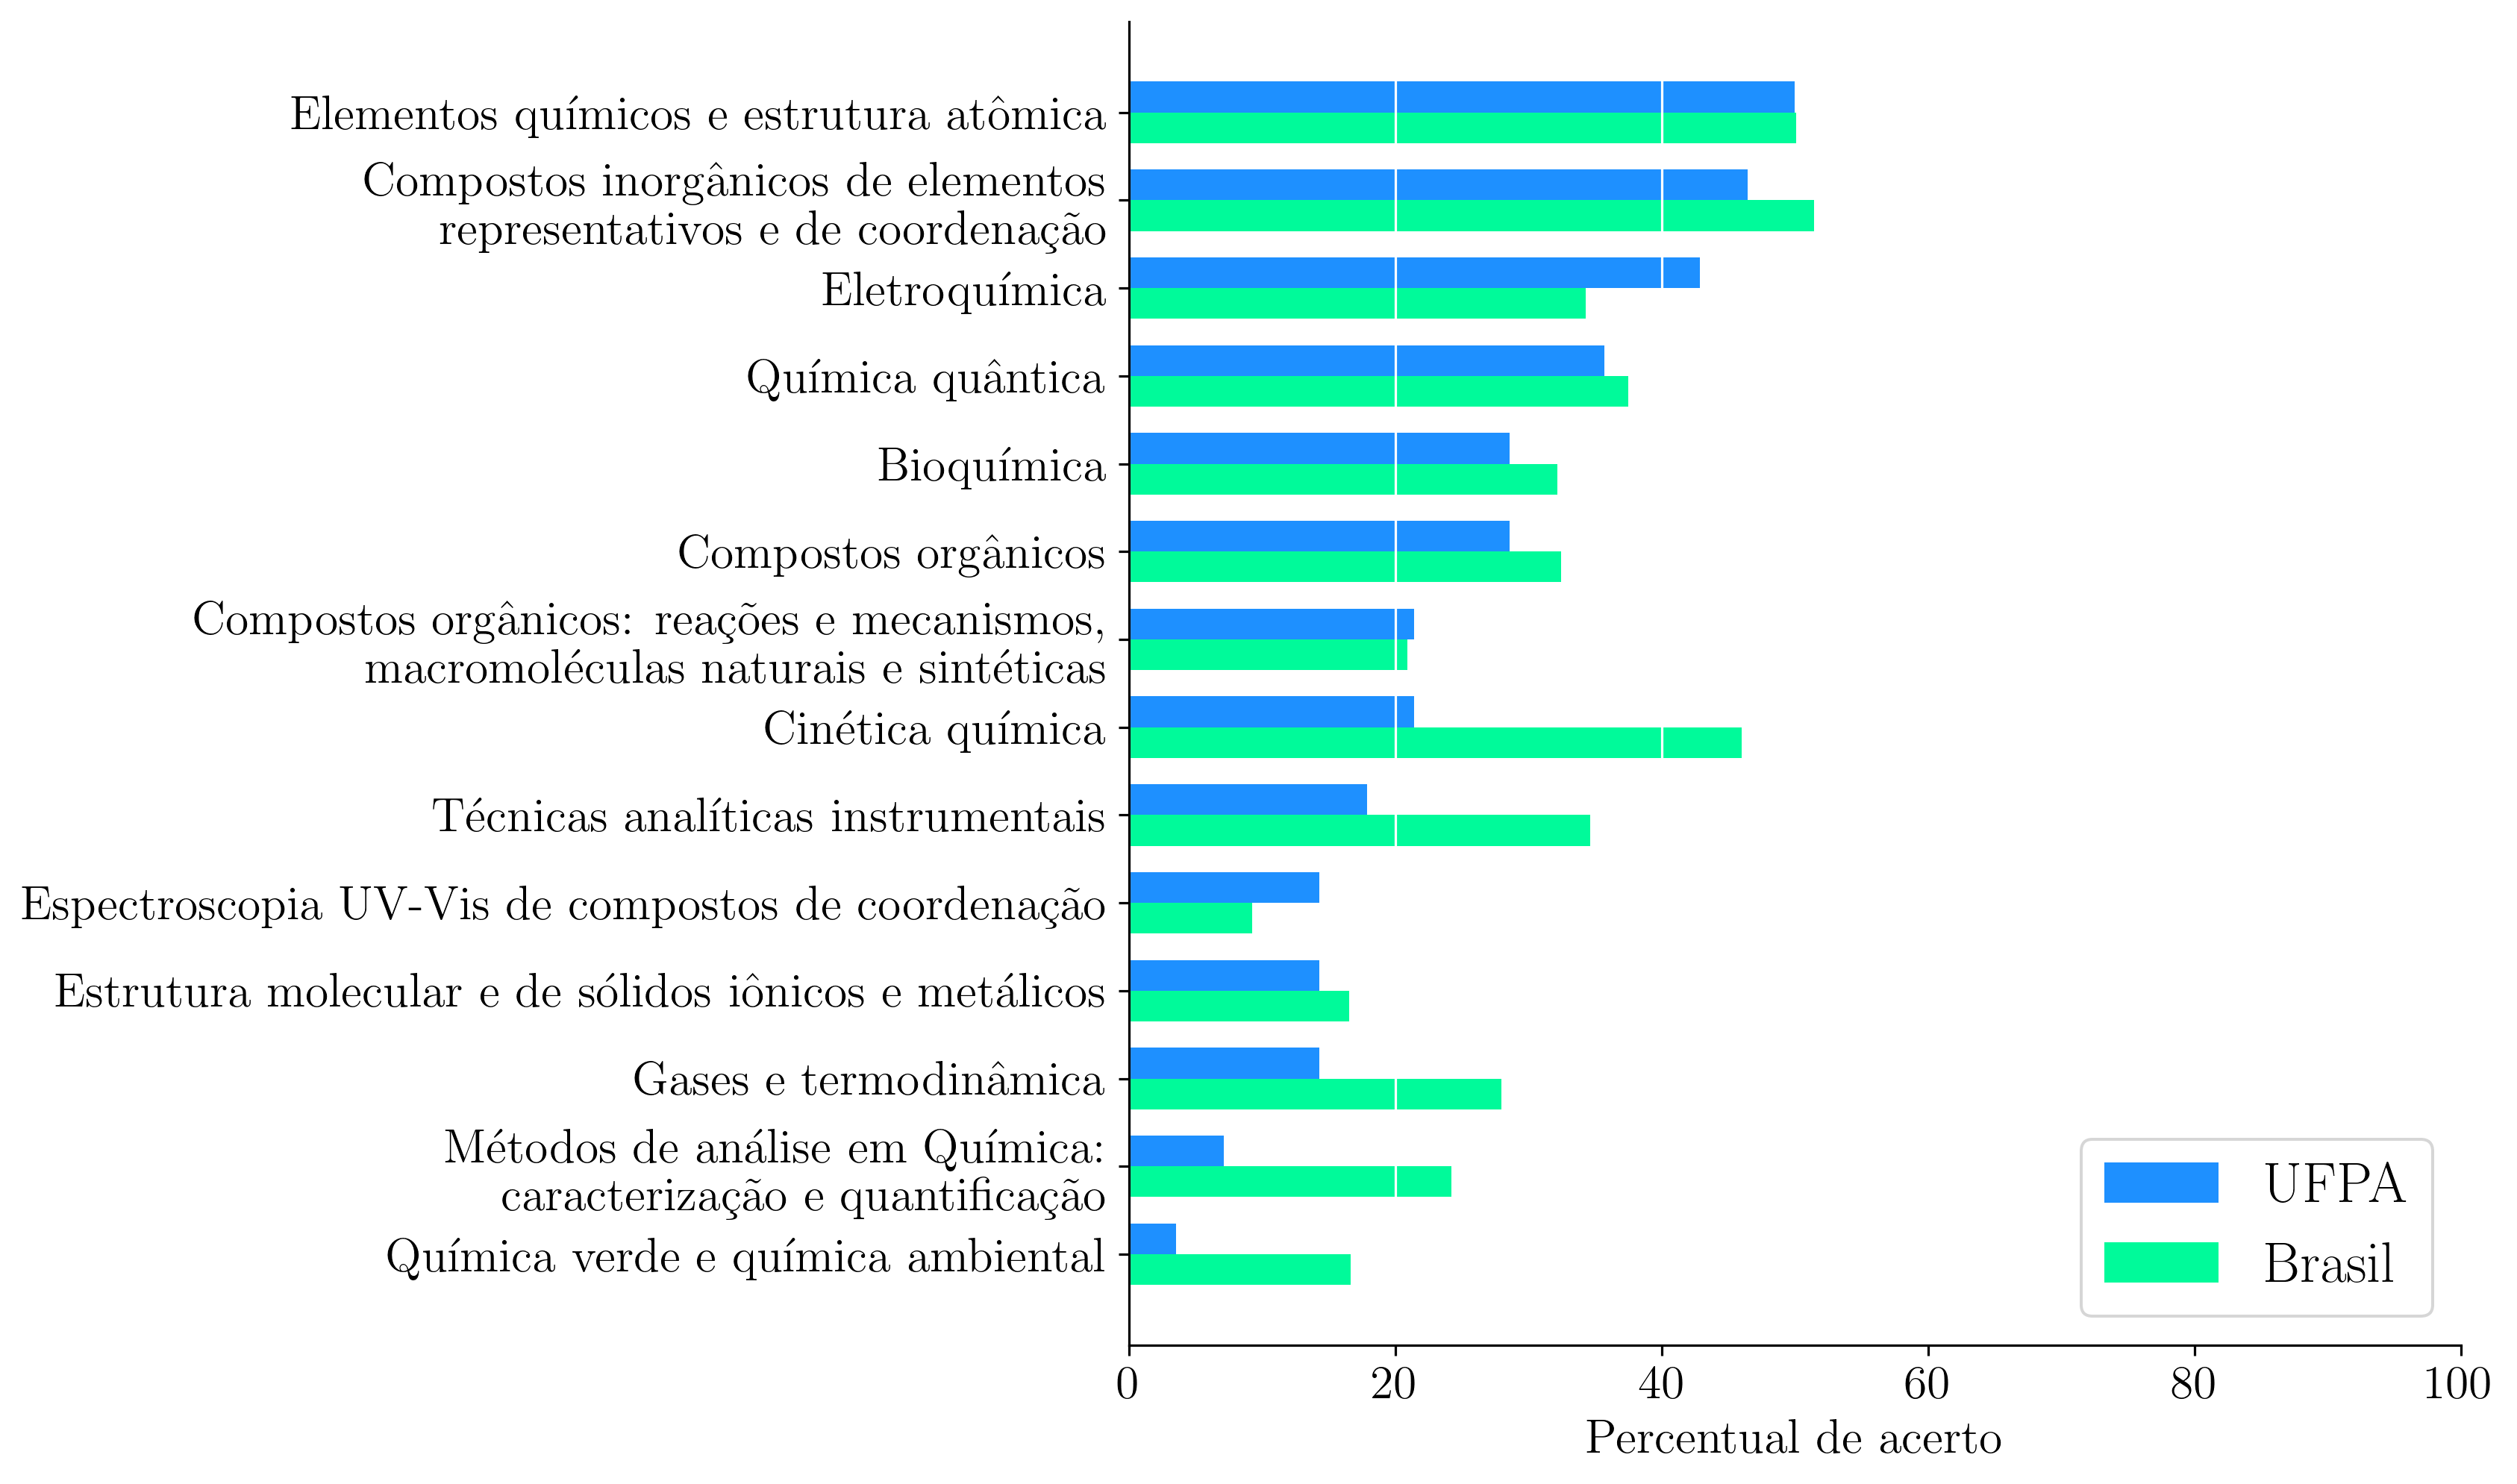

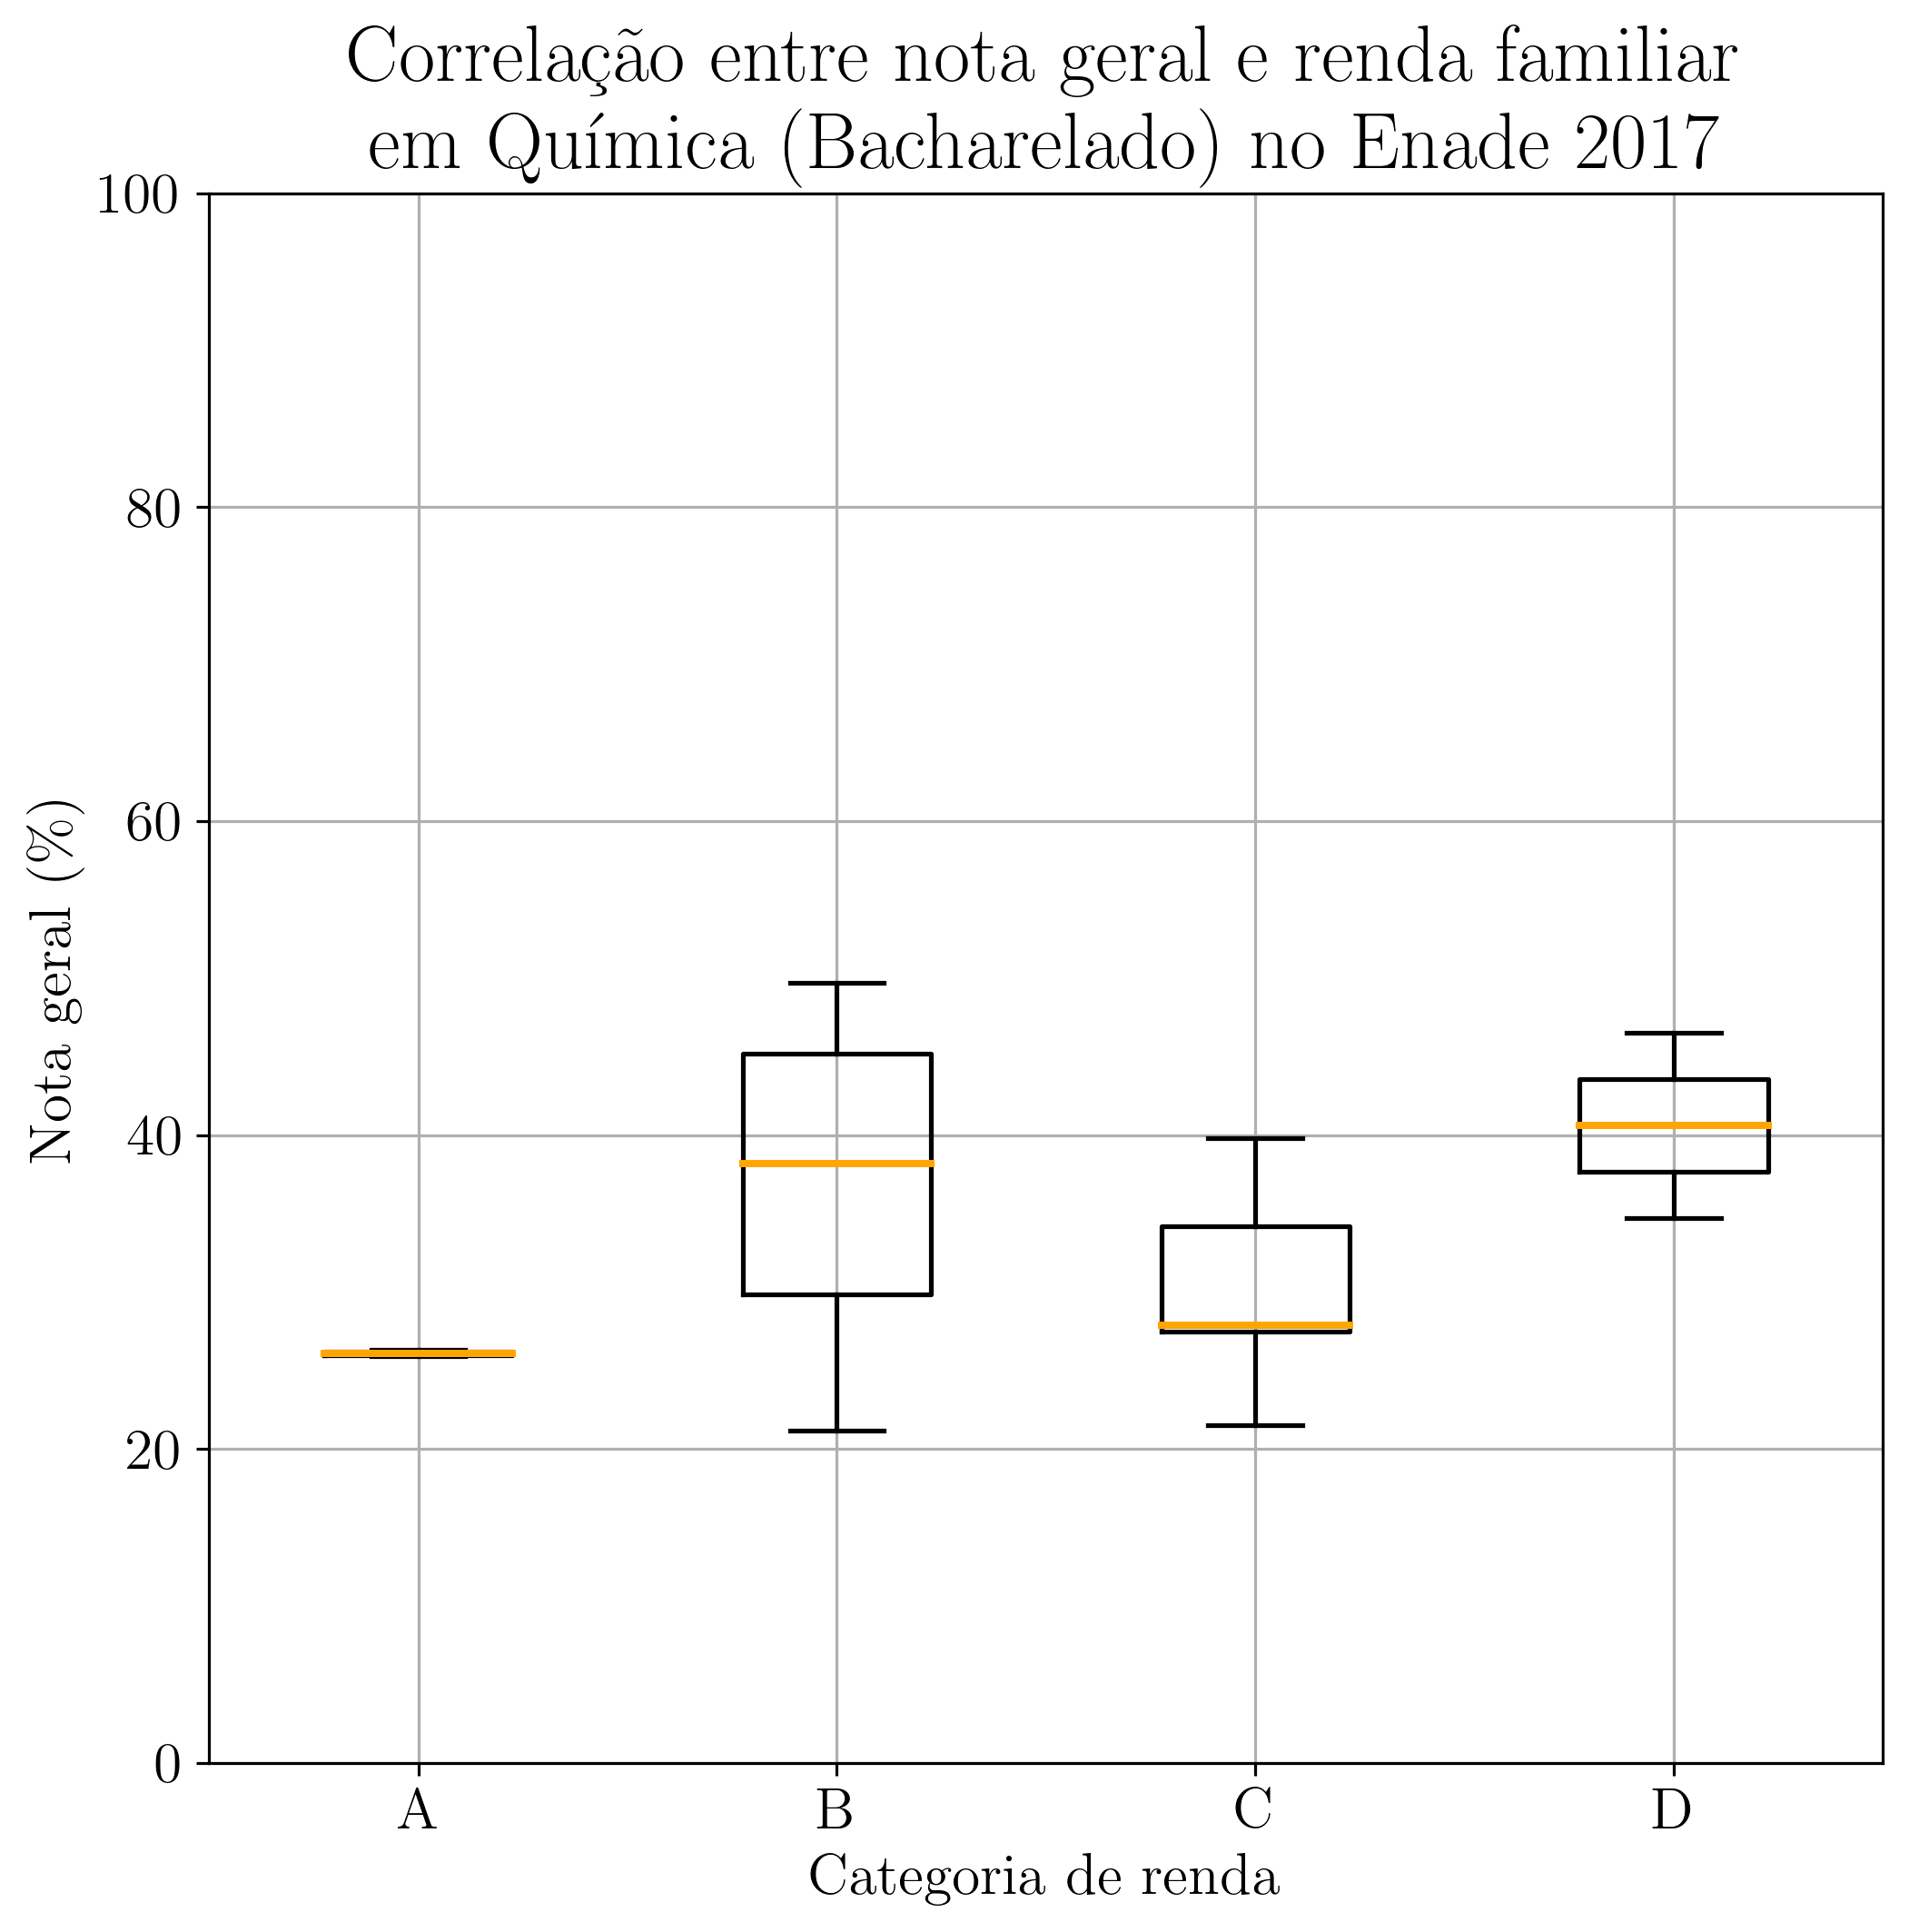

\
                                                                               Tema   
0                                                                        Bioquímica   
1                                                                  Cinética química   
2               Compostos inorgânicos de elementos representativos e de coordenação   
3                                                               Compostos orgânicos   
4   Compostos orgânicos: reações e mecanismos, macromoléculas naturais e sintéticas   
5                                            Elementos químicos e estrutura atômica   
6                                                                     Eletroquímica   
7                                 Espectroscopia UV-Vis de compostos de coordenação   
8                              Estrutura molecular e de sólidos iônicos e metálicos   
9                                                             Gases e termodinâmica   
10                    Métodos de análise em Química: caracterização e quantificação   
11                                                                 Química quântica   
12                                                Química verde e química ambiental   
13                                                Técnicas analíticas instrumentais   

                                                                              \
                                                     IES Nº de participantes   
0                                                    548                   4   
1   Universidade Federal Rural do Rio de Janeiro (UFRRJ)                  22   
2                                                      1                   7   
3                                                    694                  22   
4                                                    548                   4   
5                                                      1                   7   
6                                                      1                   7   
7                                                    592                   9   
8          Universidade Federal do Espírito Santo (UFES)                  27   
9                                                      1                   7   
10                                                   577                   9   
11                                                   592                   9   
12                                                     1                   7   
13                                                   548                   4   

   Desempenho (%)         
     Melhor curso   UFPA  
0           50.00  28.57  
1           72.73  21.43  
2           71.43  46.43  
3           48.86  28.57  
4           50.00  21.43  
5           85.71  50.00  
6           78.57  42.86  
7           44.44  14.29  
8           40.74  14.29  
9           57.14  14.29  
10          44.44   7.14  
11          77.78  35.71  
12          42.86   3.57  
13          62.50  17.86

In [68]:
#Driver code
if __name__ == '__main__':
    
    print("==================================================================")
    print("Análise comparativa de desempenho dos cursos do ICEN no ENADE 2017")
    print("==================================================================\n")

    print("Códigos dos cursos:\n")
   
    for k, v in NATIONAL_COURSE_CODES.items():
        print(f"{v}:   \t{k}", end='\n')

    try:
        course_code = int(input("\nInsira um código de curso: "))
    
    except (ValueError):
        print("\nCódigo inválido inserido.")
    
    else:
        try:
            plot_performance_graph(course_code, ratio_graph=True)
            household_income_score_correlation(course_code)
            show_best_hei_ranking(course_code, True)   

        except KeyError:
           print("\nCódigo inválido inserido.")